In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
import torch
import torch.nn as nn

In [3]:
from preprocessing_utils import process_sat_data, pickle_save, pickle_load

In [4]:
data_train = pd.read_csv('../data/train.csv')
data_test = pd.read_csv('../data/track1/test.csv')

In [5]:
train_data = data_train.copy(deep=True)
test_data = data_test.copy(deep=True)

In [6]:
process_sat_data(train_data, test_data, scale=10000)

In [7]:
class SatNet(nn.Module):
    def __init__(self, name, omega, mean, diff):
        super(SatNet, self).__init__()
        self.name = name
        self.w = nn.Parameter(omega)
        self.off = nn.Parameter(mean)
        self.a1 = nn.Parameter(diff)
        self.a2 = nn.Parameter(diff)
        self.p1 = nn.Parameter(torch.randn(1))
        self.p2 = nn.Parameter(torch.randn(1))
    def forward(self, t):
        s1 = self.a1 * torch.cos(self.p1 + self.w * t)
        #s2 = self.a2 * torch.cos(self.p2 + self.w * t * 2)
        s = self.off + s1 #+ s2
        v1 = - self.a1 * self.w * torch.sin(self.w * t + self.p1)
        #v2 = - self.a2 * self.w * torch.sin(self.w * t + self.p2) * 2
        v = v1 #+ v2
        return [s, v]

In [11]:
def plot_axis(x, y_true, y_pred, ellipse_id, axis):
    axis_name = [' (X)', ' (Y)', ' (Z)']
    plt.scatter(x, y_true, label='Path')
    plt.scatter(x, y_pred, label='SatNet')
    plt.title('Ellipse: ' + str(ellipse_id) + axis_name[axis])
    plt.legend()

In [12]:
def plot_curves(sat_id, ellipse_id, data, sim=True):
    cols = ['x', 'y', 'z']
    if(sim):
        cols = [(axis + '_sim') for axis in cols]
    cols += ['epoch']
    sat_model = pickle_load('../data/train-sim/sat'+str(sat_id)+'.pickle')[ellipse_id]
    sat_data = data[data['sat_id'] == sat_id].loc[:, cols]
    sat_data = sat_data.iloc[ellipse_id * 24 : (ellipse_id + 1) * 24, :]
    data = sat_data.values[:, [0,1,2]]
    time = torch.from_numpy(sat_data['epoch'].values).float()
    pred = []
    for axis in ['x', 'y', 'z']:
        model = sat_model[axis]
        pred.append(model(time)[0].detach().numpy())
    pred = np.array(pred)
    time = time.detach().numpy()
    plt.figure(figsize=(15,4))
    for axis in range(3):
        plt.subplot(1,3,axis+1)
        plot_axis(time, data[:, axis], pred[axis], ellipse_id, axis)

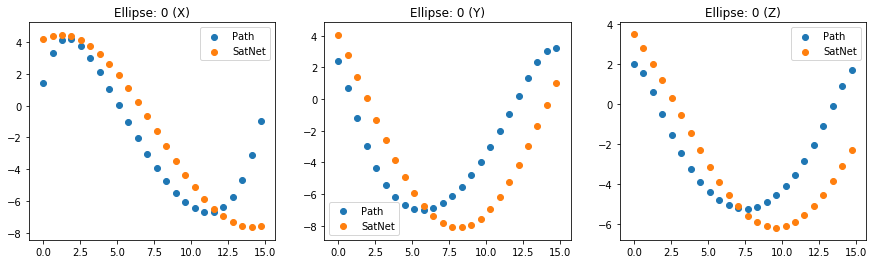

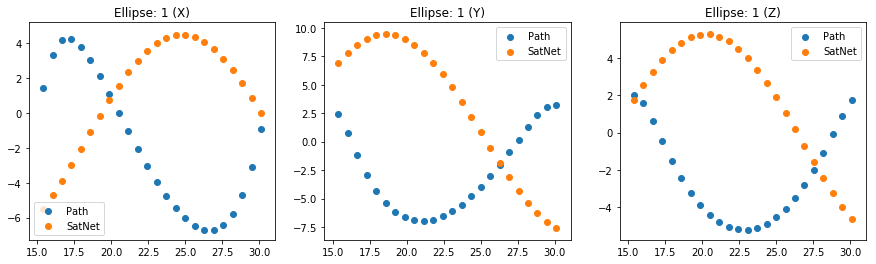

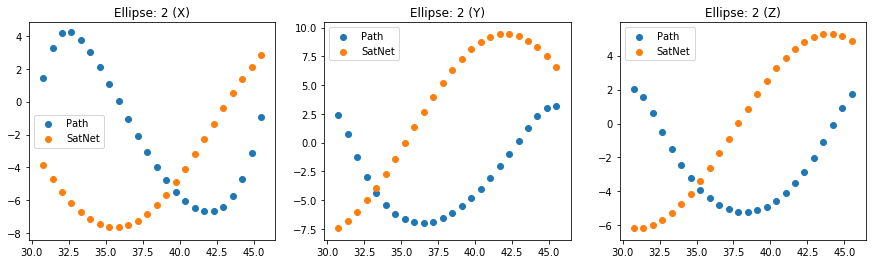

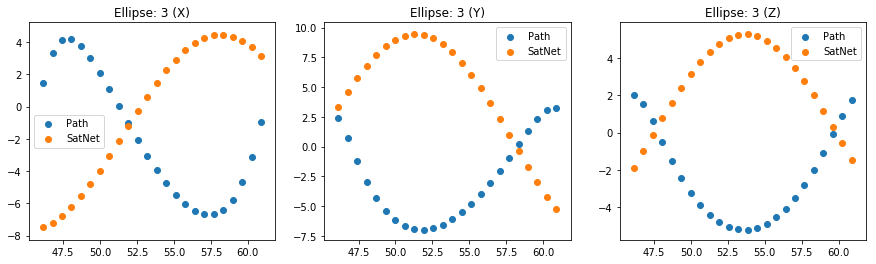

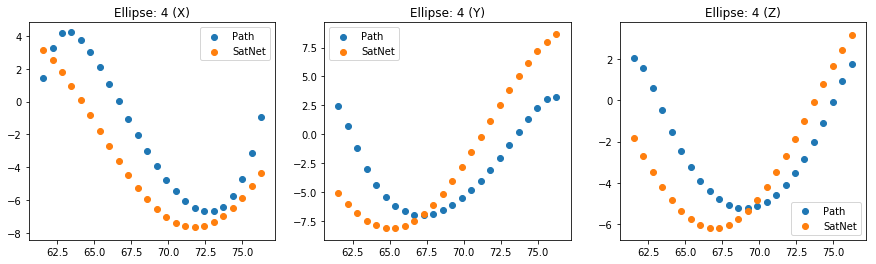

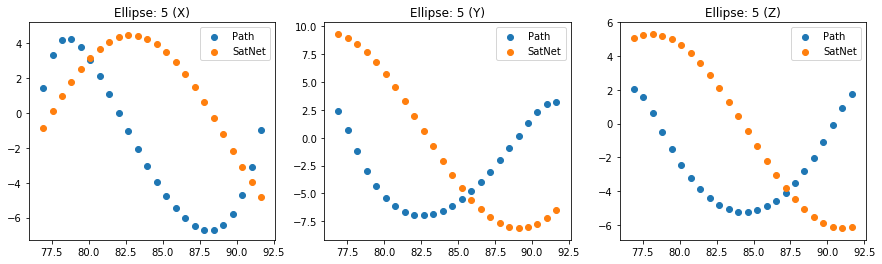

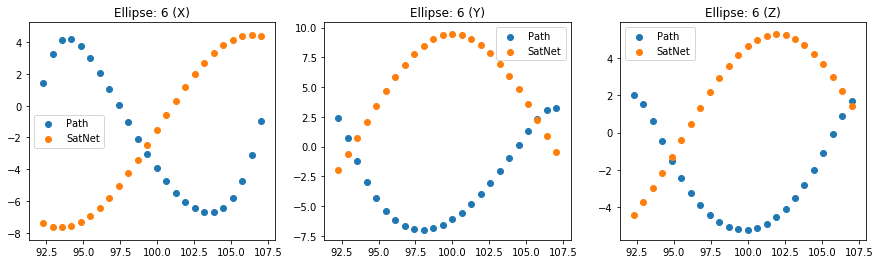

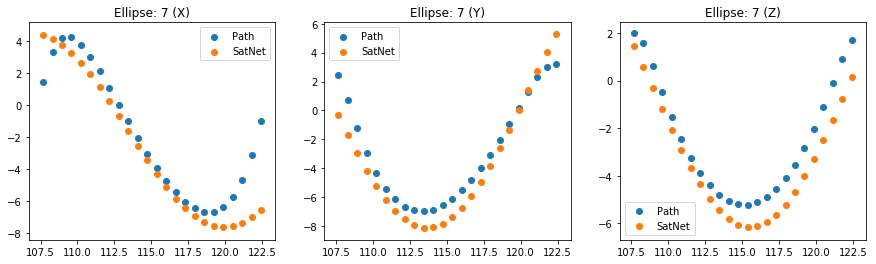

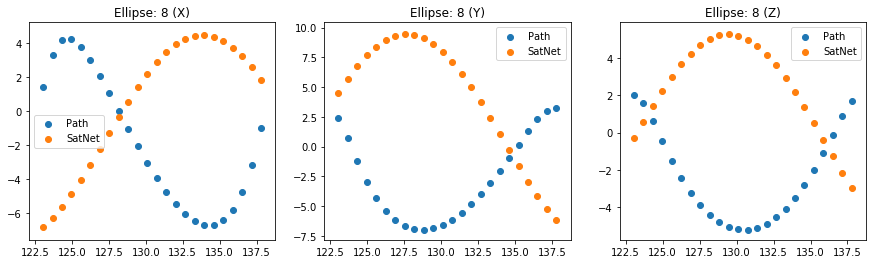

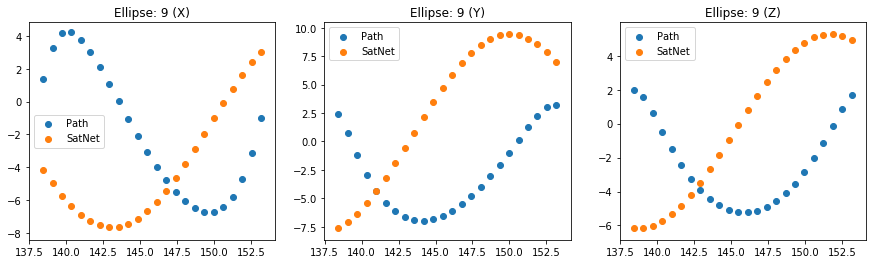

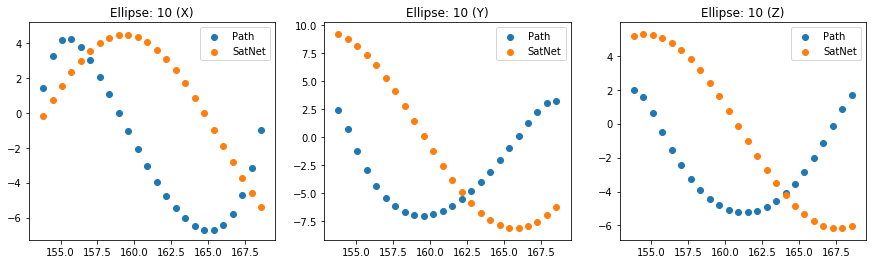

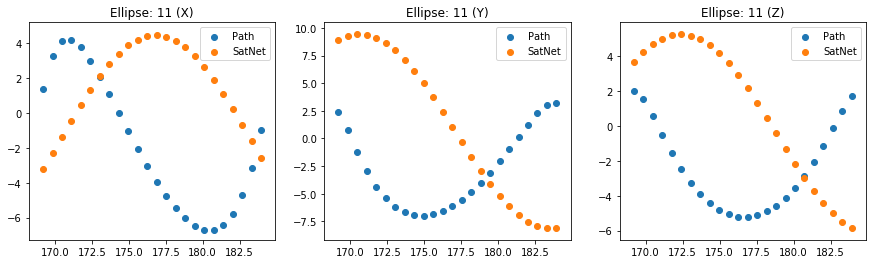

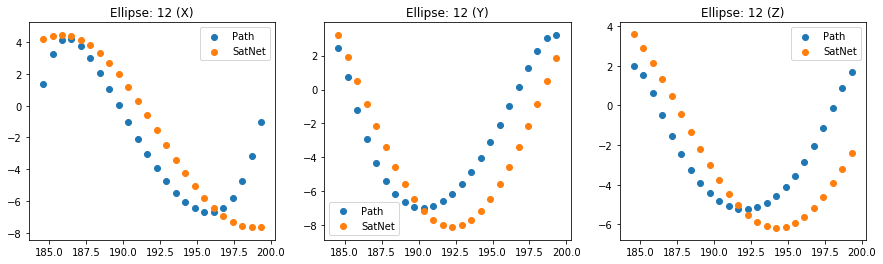

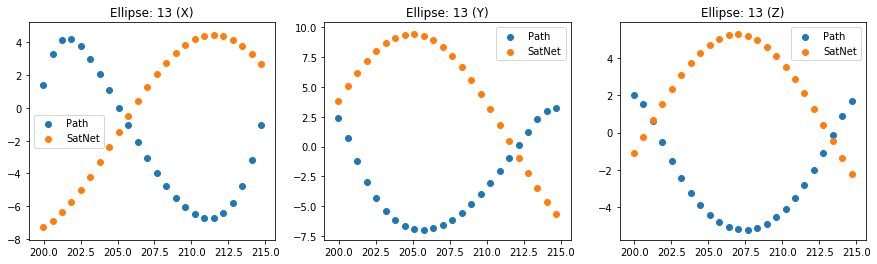

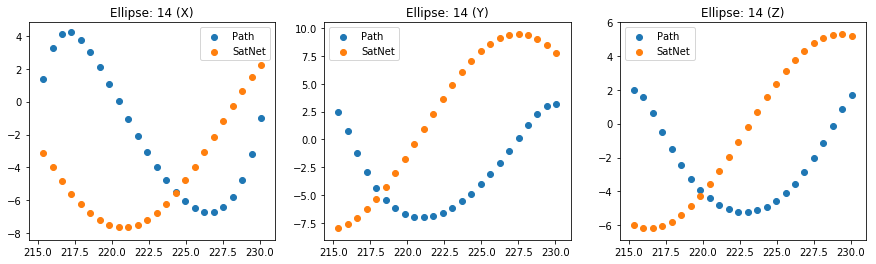

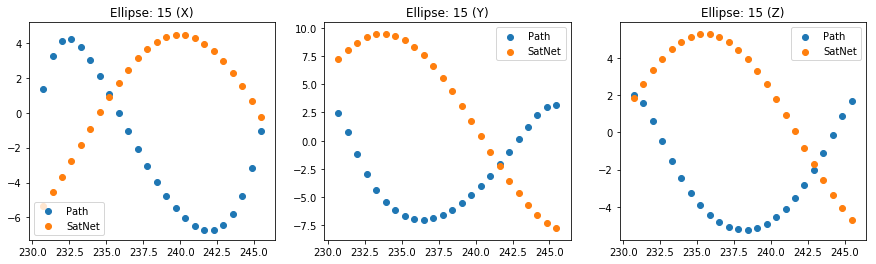

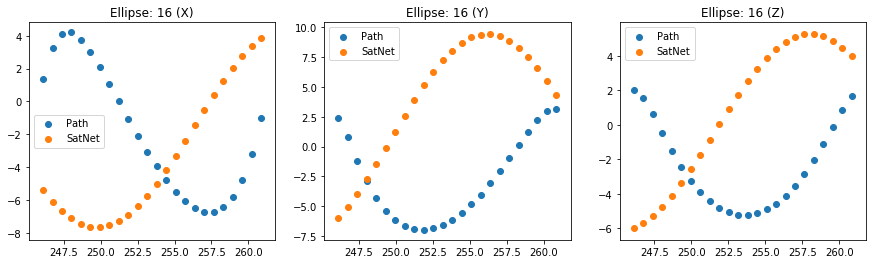

In [13]:
sat_id = 6
for ellipse_id in range(17):
    plot_curves(sat_id, ellipse_id, train_data)